# *Uncertainty Propagation*: Polynomial approximation and interpolation (Tutorial 1)

### Problem statement
A key problem statement in the field of Uncertainty Quantification is _Uncertainty Propagation_. In general, such problems consist of the following ingredients:

* A vector of uncertain inputs, expressed as random-variables: $X = (X_1, X_2, \dots, X_d)$;
* A probability density function $p(X)$ describing the (possibly correlated) distribution of the inputs;
* A function $u(X)$ respresenting the action of (e.g.) our CFD code on the inputs.

Our goal is to estimate statistics (mean, variance, etc.) of the random-variable $Y = u(X)$.  We assume the following:

* $X_1, \dots, X_d$ are distributed *independently*, $X_i \perp X_j,\; i\neq j$, so $p(X) = p_1(X_1) p_2(X_2) \cdots p_d(X_d)$;
* We basically know everything about $p(X)$, e.g. its moments, its pdf, its shape, etc.

### Application examples
We will consider a simple test function for convenience. Let $X_1$ and $X_2$ be uniformly distributed on $[0, 1]$ and consider
$$
    u(X) = \left(\frac{1}{50} + \left(X_1 - \frac{7}{12}\right)^4\right)^{-1} \left(\frac{1}{25} + \left(X_2 - \frac{2}{3}\right)^2\right)^{-1}
$$
Our goal is to determine the mean of $u(X)$. As $u$ is known explicitly in this case (which is for CFD not the case), we know that:
$$
    \mathbb{E}[u] := \int_0^1 \int_0^1 u(x_1,x_2) p(x_1,x_2)\,\mathrm{d}x_1\,\mathrm{d}x_2 = 421.864040287311503221212881103111494455415403225767785...
$$

Contours of the function $u(X)$ are as follows (we also include helper libraries here, so always start with executing the following cell):

In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate

def u(x1, x2): return 1/(1/50 + (x1 - 7/12)**4) * 1/(1/25 + (x2-2/3)**2)

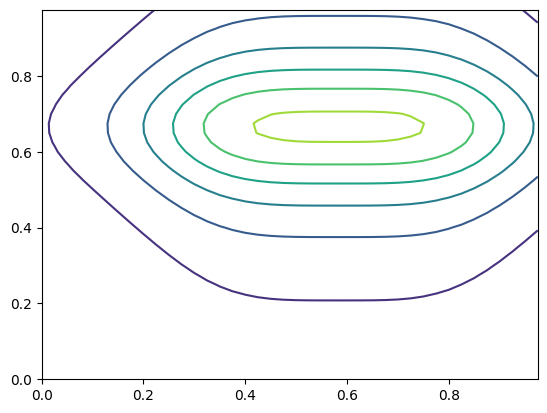

In [46]:
x = np.arange(0, 1, 0.025)
y = np.arange(0, 1, 0.025)
X, Y = np.meshgrid(x, y)
Z = u(X, Y)
plt.figure()
CS = plt.contour(X, Y, Z)

## Monte Carlo

The Monte Carlo approach consists of sampling from $X_1$ and $X_2$ and evaluating $u(X)$ there. So a crude approximation of $\mathbb{E}[u]$ is the following:

In [47]:
X1 = np.random.rand(10, 1)
X2 = np.random.rand(10, 1)

np.mean(u(X1, X2))

340.151549043633

**EXERCISE 1**

Say $E^\text{MC}_N$ is the mean determined in this way using $N$ samples. Extend the snippet above to determine a list with means determined using $N = 10^0, \dots, 10^7$ samples. For each estimate, determine

$$e_N = \left|E^\text{MC}_N - \mathbb{E}[u]\right|$$

Create a $N - e_N$ log-log plot. What do you observe? Do you expect $e_N \to 0$ for $N \to \infty$? What is the *rate* of convergence?  Note: The `scipy.stats` function `linregress()` is a handy way of fitting a line to data - just remember to pass it the log-log values!  The first returned value is the slope of the fit.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

[-4.56023557e+01 -4.56023557e+02 -4.56023557e+03 -4.56023557e+04
 -4.56023557e+05 -4.56023557e+06 -4.56023557e+07 -4.56023557e+08]


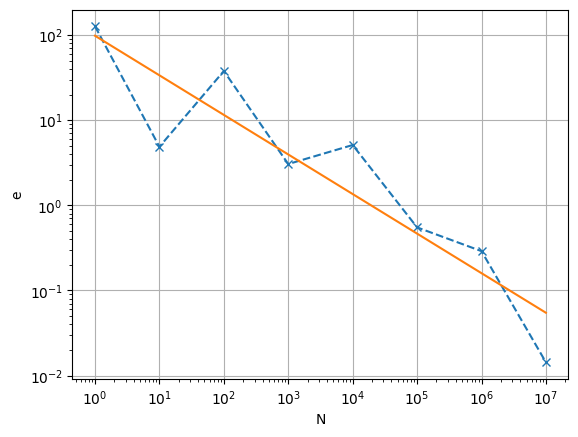

In [48]:
from scipy import stats
n_max = 8
N_arr = np.zeros(n_max,  dtype = int)
err_arr = np.zeros(n_max)
EMC_arr = np.zeros(n_max)

Eu = 421.864040287311503221212881103111494455415403225767785 # exact expectation

for i in range(n_max):
    i = int(i)
    N_arr[i] = 10**i

    X1 = np.random.rand(N_arr[i], 1)
    X2 = np.random.rand(N_arr[i], 1)

    EMC_arr[i] = np.mean(u(X1, X2))
    err_arr[i] = np.abs( EMC_arr[i]-Eu)

plt.figure()
plt.loglog(N_arr, err_arr, '--', marker = 'x')
res = stats.linregress(np.log10(N_arr), np.log10(err_arr))
# print(res)
print((res.slope*N_arr) * 10.**res.intercept)
plt.loglog(N_arr, 10**(res.slope*np.log10(N_arr)) * 10.**res.intercept)
plt.xlabel('N')
plt.ylabel('e')
plt.grid(True)

You may see that the Monte-Carlo estimate is noisy - this is of course inherent to the method!  If you want to see the standard-deviation at each $N$, you could (extra credit): run MC multiple times at each value of $N$; compute the sample variance, and then standard-deviation.  You can then plot $\mu \pm \sigma$ on your convergence plot.

## Interpolation: "Probabilistic collocation"

Monte Carlo almost always works, irrespective of the regularity (i.e. smoothness) of $u(\cdot)$, with a convergence rate *independent* of the dimension of the input.  Both these properties are extremely unusual for a numerical method.  More typical is the following: a method with a convergence rate of e.g. $\epsilon \propto 1/N^p$ in 1d ($p$th-order), has a rate of $\epsilon \propto 1/\sqrt[d]{N^p}$ in $d$-dimensions (assuming a tensor-product generalization - Q: Consider why).  So a 1st-order method ($p=1$ will be equal or worse than Monte-Carlo in $\geq 2$-dimensions.  A 2nd-order method ($p=2$) will be equal or worse in $\geq 4$-dimensions.

However, especially if accurary requirements are strict, Monte-Carlo requires an excessive number of function evaluations.  This is especially onerous if a single function evaluation takes a very long time (the case of CFD!).  A different approach, as discussed in the lectures, is stochastic polynomial quadature.

**EXERCISE 2.0**

We start with a simple, 1D example. Let $X_2 = 2/3$ and let (again) $X_1$ be uniformly distributed between $[0, 1]$. Then:
$$
\mathbb{E}[u] := \int_0^1 u(x, 2/3) \,\mathrm{d} x = 913.2377633133653539471472717582753...
$$
Since the background (input) distribution is uniform, we know the Gauss-Legendre quadrature rule is optimal, and the Legendre polynomials form an orthogonal basis.  As in the lectures `numpy` implements this rule, but on the interval $[-1,1]$.  Scale the nodes and weights to the required interval $[0,1]$.


In [49]:
def scaled_gausslegendre(M):
    """Return the Gauss-Legendre rule with M+1 nodes on [0,1]"""
    x, w = np.polynomial.legendre.leggauss(M+1)
    # Scaling of weights and nodes
    x = 0.5*x + 0.5
    w = w/2
    return x, w

def quad_gausslegendre(f, M):
    """Return the Gauss-Legendre approximation of the integral of f on [0,1]"""
    x, w = scaled_gausslegendre(M)
    return np.sum(w*f(x)) # Implement quadrature rule

print("quad_gausslegendre estimate of integral of x**2 on [0,1]:", quad_gausslegendre(lambda x: x**2, 4))
print("Exact of integral of x**2 on [0,1] (x**3 / 3):", 1/3)


quad_gausslegendre estimate of integral of x**2 on [0,1]: 0.33333333333333337
Exact of integral of x**2 on [0,1] (x**3 / 3): 0.3333333333333333


You can now plot the test function, sampled at your nodes, and interpolated with a polynomial there.  We use the `scipy` function `BarycentricInterpolator(x, y)`, which returns a function (a polynomial) which interpolates the input data.  (If you're not sure how it does this, implement a version yourself!)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BarycentricInterpolator.html

In [50]:
x, w = scaled_gausslegendre(5)
def u_1d(x): return u(x, 2/3)
Y = u_1d(x)
uhat = interpolate.BarycentricInterpolator(x, Y)

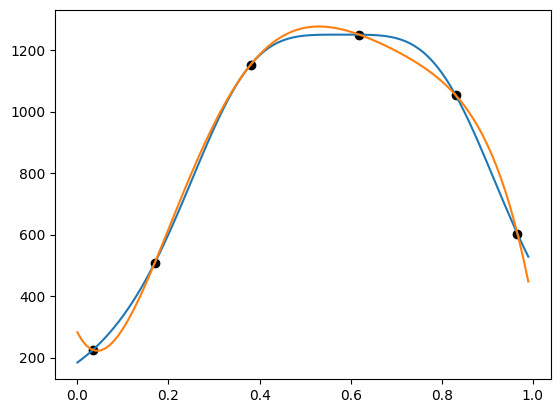

In [51]:
plt.figure()
xx = np.arange(0, 1, 0.01)

plt.plot(xx, u_1d(xx))
plt.plot(xx, uhat(xx))
plt.scatter(x, Y, c='black') # plt.scatter(X, Y, c='black')

Let $\hat{u}_N$ be the polynomial in the figure above. The following integral can now be determined exactly (!):
$$
    \mathbb{E}[\hat{u}_N] = \int_0^1 \hat{u}_N(x) \,\mathrm{d} x \simeq \mathbb{E}[u]
$$

You may use the following function for this (here $M = 15$):

In [52]:
print( quad_gausslegendre(u_1d, 15) )

913.2377897458339


**EXERCISE 2.1**

Say $E^\text{IP}_M$ is the mean determined in this way using $M+1$ evaluations of the function using the Gauss-Legendre quadrature rule.  Plot again convergence of this rule for this problem.  That is, for a sequence of $Ms$ determine:

$$e_M = \left|E^\text{IP}_M - \mathbb{E}[u]\right|.$$

Create a $N$ against $e_N$ log plot. What do you observe? Does $e_N \to 0$ hold (for $N \to \infty$)? What is the rate of convergence? How many nodes do you need to reach an error of $10^{-8}$?  And an error of $1$%?

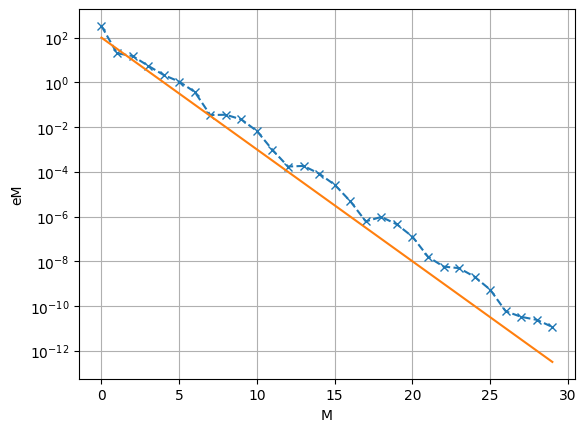

In [53]:
def plot_log_ref(x, m, y_int):
    return 10.**(x*m) * 10.**y_int

viz = np.arange(30)

m_max = 30
M_arr = np.arange(m_max)
err_arr = np.zeros(m_max)
EIP_arr = np.zeros(m_max)

Eu = 913.2377633133653539471472717582753 # exact

for m in range(m_max):
    EIP_arr[m] = quad_gausslegendre(u_1d, m)
    err_arr[m] = np.abs(EIP_arr[m]-Eu)
    
ref_slope = -1/2
    

plt.figure()
plt.semilogy(M_arr, err_arr, '--', marker = 'x')
plt.semilogy(viz,plot_log_ref(viz,ref_slope,2), label = f"slope = 10 ^ {ref_slope}")
plt.xlabel('M')
plt.ylabel('eM')
plt.grid(True)

The original function has **two** variables. But that is not that complex, we can simply use the tensor-product idea, and apply our interpolation procedure twice in a loop as follows:

In [54]:
M1, M2 = 5, 6
x1, w1 = scaled_gausslegendre(M1)
x2, w2 = scaled_gausslegendre(M2)

quad_mat = np.empty((M1+1,M2+1))


for i in range(M1+1):
    for j in range(M2+1):
        quad_mat[i,j] = u(x1[i], x2[j])*w1[i]*w2[j]
        # sum += u(x1[i], x2[j])*w1[i]*w2[j]

# np.outer(u(x1)*w1,u(x2)*w2)
# quad_mat
sum = np.sum(quad_mat)
# print(sum)

**EXERCISE 3**

Create a similar plot as in Exercise 1 and 2: plot $N - e_N$, where $N$ is the *total* number of nodes used and $e_N$ is the error. What do you oberserve? $e_N \to 0$? What is (approximately) the rate of convergence?  How many nodes do you need to reach an accuracy of 1%?  **Note:** it's useful here to make a function called `quad2d(f, M1, M2)` that encapsulates the code in the cell above (performs the numerical quadrature in 2d and returns the answer), so you can call it for a variety of $M_1$ and $M_2$.

In [55]:
def quad2d(f, M1, M2):
    x1, w1 = scaled_gausslegendre(M1)
    x2, w2 = scaled_gausslegendre(M2)

    quad_mat = np.empty((M1+1,M2+1))


    for i in range(M1+1):
        for j in range(M2+1):
            quad_mat[i,j] = f(x1[i], x2[j])*w1[i]*w2[j]
            # sum += u(x1[i], x2[j])*w1[i]*w2[j]

    # np.outer(u(x1)*w1,u(x2)*w2)
    # quad_mat
    return np.sum(quad_mat)

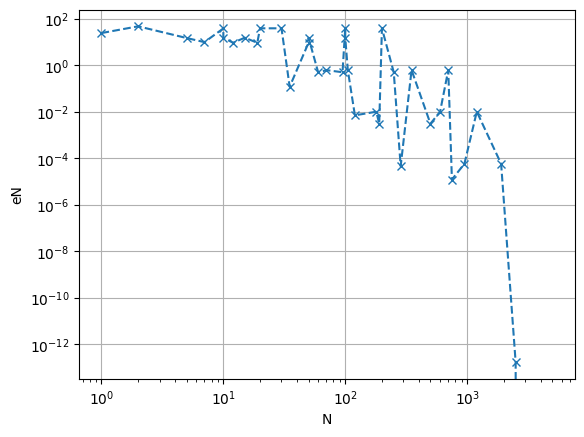

In [56]:
M1_arr = np.array([1, 5, 10, 15, 50, 100])
M2_arr = np.array([1, 2, 7, 12, 19, 50])

N_arr = np.zeros(len(M1_arr)*len(M2_arr))
EIP2d_arr = np.zeros(len(M1_arr)*len(M2_arr))

for i in range(len(M1_arr)):
    for j in range(len(M2_arr)):
        EIP2d_arr[i*len(M2_arr)+j] = quad2d(u, M1_arr[i], M2_arr[j])
        N_arr[i*len(M2_arr)+j] = M1_arr[i]*M2_arr[j]


# compute relative error, w.r.t. error on finest grid
# limitation: an error of 0 is shown on the finest grid point
# warning: ensure M1, M2 are in ascending order!
Eu = EIP2d_arr[-1]
err_arr = np.abs(EIP2d_arr-Eu)


sort_idx = np.argsort(N_arr)
N_arr = N_arr[sort_idx]
err_arr = err_arr[sort_idx]

plt.figure()
plt.loglog(N_arr, err_arr, '--', marker = 'x')
plt.xlabel('N')
plt.ylabel('eN')
plt.grid(True)

## Smolyak Sparse grid - Advanced material

In multiple dimensions, a vastly improved way of performing the interpolation procedure is the Smolyak sparse grid concept.  In this tutorial, you will implement your own sparse grid, based on your tensor-product formula from the previous tutorial.  The same function as above is used initially, but then we move on to XFoil and attempt to evaluate statistics of surface pressure due to uncertain onflow conditions.  Remember to execute the notebook up to this point, to initialize `u()`, your `quad2d()`, etc.

### Clenshaw-Curtis quadrature
Remember for sparse grids to work well, we need to base them on 1d rules with *nested* nodes.  The 1-dimensional rule constructed above (Legendre) is not nested.  The Clenshaw-Curtis rule *is* nested - the nodes and weights are implemented in the function below.  Verify (by plotting) the nesting property for these rules, namely that if $\mathcal{X}_M = \{x_0,\dots,x_M \}$ is the set of nodes of the $M$-th rule, then
$$
\mathcal{X}_0 \subset \mathcal{X}_2 \subset \mathcal{X}_4 \subset \mathcal{X}_8 \subset \cdots \subset \mathcal{X}_{2^j}.
$$
Perform also some basic checks on the rule, integrals of $1$, $x$, etc. correct.

**Note:** The function below computes the weights by integrating the Lagrange polynomials corresponding to the nodes.  Why does this work?

[1, 2, 4, 8, 16, 32]


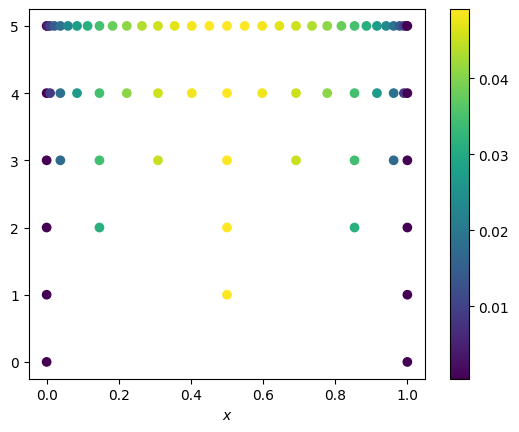

In [57]:
def scaled_clenshaw(M):
    """Return nodes,weights of Clenshaw-Curtis quadrature with M+1 nodes on [0,1]"""
    if M == 0: return np.array([0.5]), np.array([1.]), # Special case
    x = np.cos(np.linspace(0, np.pi, M+1)[::-1])/2 + 1/2   # Nodes have an easy formula
    w = np.zeros(M+1)                                # Weights don't! So compute numerically!
    for i in range(M+1):
        lagrange = interpolate.BarycentricInterpolator(x, np.eye(M+1)[i])  # i-th Lagrange poly
        w[i] =  quad_gausslegendre(lagrange, M)
    return x, w

# Check subsets of scaled_clenshaw(M)

j_no = 6

j_list = [2**j for j in range(j_no)]
j_ind = [j for j in range(j_no)]
print(j_list)
for count, j in enumerate(j_list):
    
    x_clen, w_clen = scaled_clenshaw(j)
    plt.scatter(x_clen, [count]*len(x_clen), c=w_clen, marker='o')

    # print(x_clen)
# xx = np.linspace(-1,1,101)
# plt.fill_between(xx+0.5, np.exp(-xx**2/2)*2, color='k', alpha=0.1)
plt.xlabel(r'$x$')
# plt.ylim(-1,10)
plt.colorbar()


Gauss Legendre integral 913.2444064221246
Curtis Clenshaw integral 913.272761907082


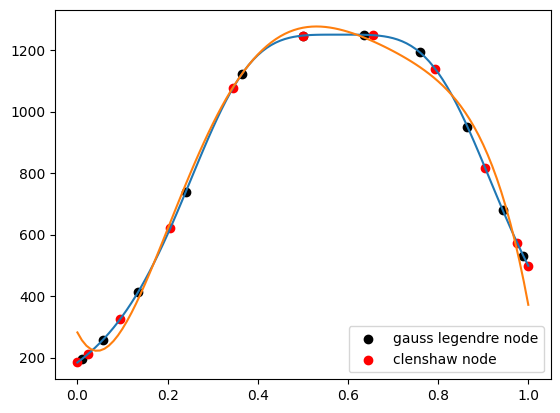

In [58]:
# Check Nodes and Integrals of Clenshaw Curtis Nodes

plt.figure()
x_gl, w_gl = scaled_gausslegendre(10)
x_clen, w_clen = scaled_clenshaw(10)

def u_1d(x): return u(x, 2/3)

Y_gl = u_1d(x_gl)
Y_clen = u_1d(x_clen)

xx = np.arange(0, 1.01, 0.01)

uhat = interpolate.BarycentricInterpolator(x, Y)

plt.plot(xx, u_1d(xx))
plt.plot(xx, uhat(xx))
plt.scatter(x_gl, Y_gl, c='black',label = "gauss legendre node")
plt.scatter(x_clen, Y_clen, c='red',label = "clenshaw node")
plt.legend()

print("Gauss Legendre integral", quad_gausslegendre(u_1d, 10) )
print("Curtis Clenshaw integral", np.sum(w_clen * u_1d(x_clen)) )


### Sparse grid construction
The Smolyak sparse grid formula we use is the following. Let  $\mathcal{Q}_M$ be the *one-dimensional* (or "univariate") quadrature rule developed in the previous section.  So
$$
\mathcal{Q}_M[f] := \sum_{i=0}^M w_i f(x_i) \simeq \int_0^1 f(x) \rho(x) \;\mathrm{d}x
$$
where $\rho(x)$ is the uniform density.  Let $\Delta_k$ be differences of two of these rules as follows:
$$
\Delta_0 := \mathcal{Q}_0, \quad\Delta_1 := \mathcal{Q}_1-\mathcal{Q}_1, \quad\Delta_2 := \mathcal{Q}_2 - \mathcal{Q}_1, \quad\Delta_3 := \mathcal{Q}_3 - \mathcal{Q}_2,\quad\dots
$$
so we can also evaluate e.g. $\Delta_M[f]$ and get some number.
Then the Smolyak grid we seek is:
$$S_K = \sum_{i + j \leq K} \left(\Delta_{g(i)} \otimes \Delta_{g(j)}\right),$$
with 
$$
g(j) = \begin{cases}0 &\text{if $j = 0$} \\ 2^j &\text{if $j\geq 1$}.\end{cases}
$$

Note that this $g(\cdot)$ is necessary because we don't want to use *every* degree $M$ of the quadrature rule.  One reason is that Clenshaw-Curtis is not perfectly nested in the sense that $\mathcal{X}_M \subset \mathcal{X}_{M+1}$ for all $M$.  The nested property only holds for the $M = 2^i$ rules.  So the $g(\cdot)$ function selects those rules only.  It is the mapping from the index of the sparse grid *level* to the degree of the rule $M$.

**Hint**: "$\otimes$" is linear, so
$$\Delta_m \otimes \Delta_n = (\mathcal{Q}_m - \mathcal{Q}_{m-1}) \otimes (\mathcal{Q}_n - \mathcal{Q}_{n-1}) = \mathcal{Q}_m \otimes \mathcal{Q}_n - \mathcal{Q}_{m-1} \otimes \mathcal{Q}_n - \mathcal{Q}_{m} \otimes \mathcal{Q}_{n-1} + \mathcal{Q}_{m-1} \otimes \mathcal{Q}_{n-1}$$

**EXERCISE 4**

Complete the following snippet for the function Smolyak, which takes a function and a $K$ and integrates that function using a sparse grid.  Note that you can compute the primitives $\mathcal{Q}_i\otimes\mathcal{Q}_j$ using your function `quad2d()` from the previous section (remember to change the quadrature rule to Clenshaw!).  Try implementing an equivalent function `quad2d_delta()` that computes $\Delta_m \otimes \Delta_n$ using these primitives, and use that function to construct the main sum above.

In [59]:
def g(i):
    if i == 0:
        return 0
    elif i >= 1:
        return 2**i
    else:
        raise ValueError(" argument i must be greater than or equal to 0")  # TODO Implement g(), defined above
    


def quad2d_cc(f, M1, M2):
    nodes_evaluated = []
    x1, w1 = scaled_clenshaw(M1)
    x2, w2 = scaled_clenshaw(M2)
    
    quad_mat = np.zeros((M1+1,M2+1))

    for i in range(M1+1):
        for j in range(M2+1):
            quad_mat[i,j] = f(x1[i], x2[j])*w1[i]*w2[j]
            # sum += u(x1[i], x2[j])*w1[i]*w2[j]
            nodes_evaluated.append([x1[i], x2[j]])

    # np.outer(u(x1)*w1,u(x2)*w2)
    # quad_mat
    return np.sum(quad_mat), nodes_evaluated #, grid_vals



def quad2d_delta(f, l1, l2):
    
    if l1 == 0 and l2 != 0:
        a, a_nodes = quad2d_cc(f,0,l2)
        b, b_nodes = quad2d_cc(f,0,l2-1)
        return a-b, a_nodes + b_nodes
    elif l2 == 0 and l1 != 0:
        a, a_nodes = quad2d_cc(f,l1,0)
        b, b_nodes = quad2d_cc(f,l1-1,0)
        return a - b, a_nodes + b_nodes
    elif l1 == 0 and l2 == 0:
        a, a_nodes = quad2d_cc(f,0,0)
        return a, a_nodes
    else:
        a, a_nodes = quad2d_cc(f,l1,l2)
        b, b_nodes = quad2d_cc(f,l1-1,l2)
        c, c_nodes = quad2d_cc(f,l1,l2-1)
        d, d_nodes = quad2d_cc(f,l1-1,l2-1)
        return a - b - c + d, a_nodes + b_nodes + c_nodes + d_nodes
    

    # raise NotImplementedError()  # TODO Implement \Delta_l1 \otimes \Delta_l2, where l1, l2 are levels


def quad_smolyak(f, K):

    smolyak_grid = np.zeros((K+1,K+1))
    t_nodes = []

    for i in range(K+1):
        for j in range(K+1):
            val , nodes = quad2d_delta(f,g(i),g(j))
            # print(i-j,j)
            smolyak_grid[i,j] = val
            # print(nodes)
            t_nodes.extend(nodes)

    return np.sum(smolyak_grid), smolyak_grid, np.array(t_nodes)


    # raise NotImplementedError()  # TODO Implement smolyak quadrature

If you did everything correct, the following should print $1$ (or $0.9999999$, or $1.00000001$) to the screen:

In [60]:
sum_smol, grid_smol, nodes_evaluated = quad_smolyak(lambda x,y: 1, 3)
sum_smol


1.0000000000000018

**EXERCISE 5**

Extend the code of your smolyak grid such that it also returns the *nodes* where the function is evaluated.  For $K = 3, 4, \text{ and } 5$ scatter-plot your Smolyak grid.  It should look sparser than a tensor-product grid, but denser than a "one-at-a-time" grid.

_____________ K = 3 _____________
Total number of nodes: 1024
Total number of UNIQUE nodes: 289


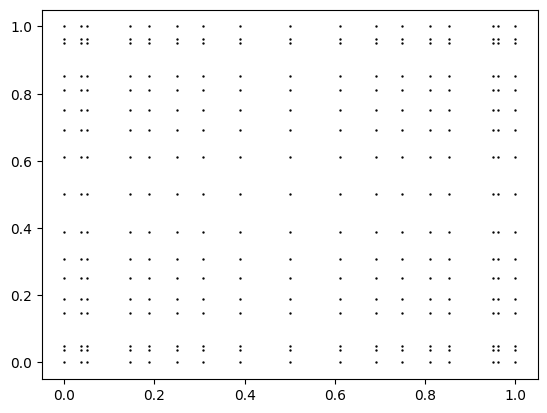

_____________ K = 4 _____________
Total number of nodes: 4225
Total number of UNIQUE nodes: 1369


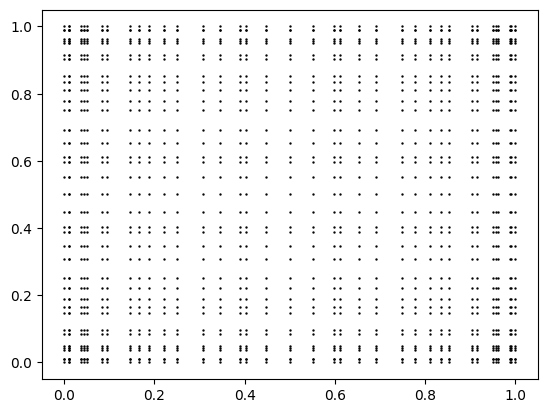

_____________ K = 5 _____________
Total number of nodes: 16900
Total number of UNIQUE nodes: 6889


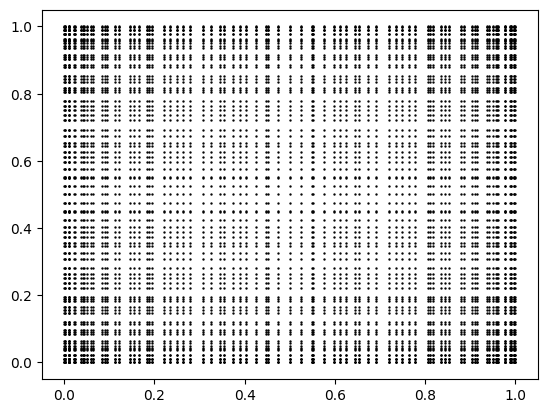

In [67]:
# plt.figure()
# grid_smol
# plt.matshow(grid_smol)
# plt.colorbar()
print("_____________ K = 3 _____________")
sum_smol, grid_smol, nodes_evaluated = quad_smolyak(lambda x,y: 1, 3)
print("Total number of nodes:",nodes_evaluated.shape[0])
unique_nodes = np.unique(nodes_evaluated, axis=0)
print("Total number of UNIQUE nodes:",unique_nodes.shape[0])

plt.figure()
plt.scatter(unique_nodes[:,0],unique_nodes[:,1], marker='o', c = 'k',s = 0.5)
plt.show()

print("_____________ K = 4 _____________")
sum_smol, grid_smol, nodes_evaluated = quad_smolyak(lambda x,y: 1, 4)
print("Total number of nodes:",nodes_evaluated.shape[0])
unique_nodes = np.unique(nodes_evaluated, axis=0)
print("Total number of UNIQUE nodes:",unique_nodes.shape[0])

plt.figure()
plt.scatter(unique_nodes[:,0],unique_nodes[:,1], marker='o', c = 'k',s = 0.5)
plt.show()

print("_____________ K = 5 _____________")
sum_smol, grid_smol, nodes_evaluated = quad_smolyak(lambda x,y: 1, 5)
print("Total number of nodes:",nodes_evaluated.shape[0])
unique_nodes = np.unique(nodes_evaluated, axis=0)
print("Total number of UNIQUE nodes:",unique_nodes.shape[0])

plt.figure()
plt.scatter(unique_nodes[:,0],unique_nodes[:,1], marker='o', c = 'k',s = 0.5)
plt.show()

**EXERCISE 6**

Redo EXERCISE 3 for the Smolyak sparse grid. Plot $N - e_N$ where $N$ is the number of *nodes* for $K = 1, \dots, 8$.  Note that computing the number of nodes is non-trivial, unlike for simple tensor-product rules.  It depends on the number of "collisions" of nodes of the component rules.

To compute the number of unique nodes, do the following: generate a `N x 2` numpy `array` of nodal coordinates `xx = array([ [0,1], [.5,.5], [.5,.5], ...])`, possibly with duplicates.  You should have this from EXERCISE 5 already.  Then apply `np.unique(xx, axis=0)` which returns a list of unique nodes, and count the length of the result.

Does $e_N \to 0$ hold again? Is this faster or slower than the tensor grid approach, or about the same?

1
2
3
4
5
eN = [1184.30939086 1068.10732779 1065.57896177 1065.56409838 1065.56409816]
log eN = [3.07346517 3.02861489 3.02758564 3.02757958 3.02757958]
N = [   9.   49.  289. 1369. 6889.]
log N = [0.95424251 1.69019608 2.46089784 3.13640345 3.83815618]
Convergence rate = -0.013025375098155352


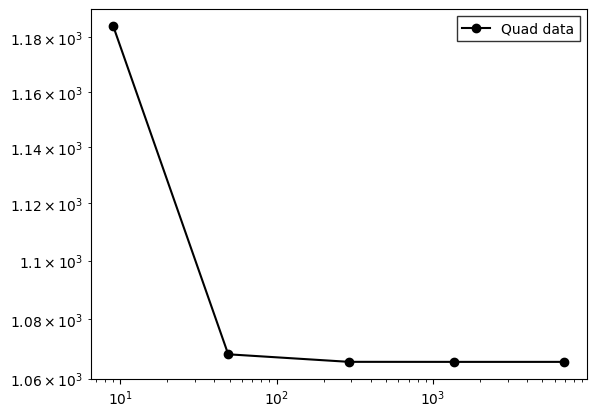

In [69]:
mean_true = 421.864040287311503221212881103111494455415403225767785

K_start = 1
K_end = 6
K_step = 1

Ks = np.arange(K_start, K_end, K_step)

N = np.zeros(shape = Ks.shape)
mean_N = np.zeros(shape = N.shape)

for i in range(len(Ks)):
    print(Ks[i])
    mean, _ ,nodes = quad_smolyak(u, Ks[i])
    mean_N[i] = mean
    N[i] = np.unique(nodes, axis=0).shape[0]
    
err = np.abs(mean_N - mean_true)

print(f"eN = {err}")
print(f"log eN = {np.log10(err)}")
print(f"N = {N}")
print(f"log N = {np.log10(N)}")

res = stats.linregress(np.log10(N), np.log10(err))
conv_rate = res.slope
print(f"Convergence rate = {conv_rate}")

plt.loglog(N, err, color = "k", marker = "o", label = "Quad data")
plt.legend(fancybox=False, edgecolor="black")
plt.show()

## XFOIL Application

Such a test function is a good approach to assess whether your UQ methodology is performing according to theoretical expectations.  But the real deal is applying everything to a real function. In this section, we will apply the implemented methods to `XFOIL` and assess the effect of uncertainty in the angle of attack, Mach number, and Reyonds number on the pressure coefficient on the airfoil.

Let's start by including the provided `xfoil` module and obtain a cp-x figure:

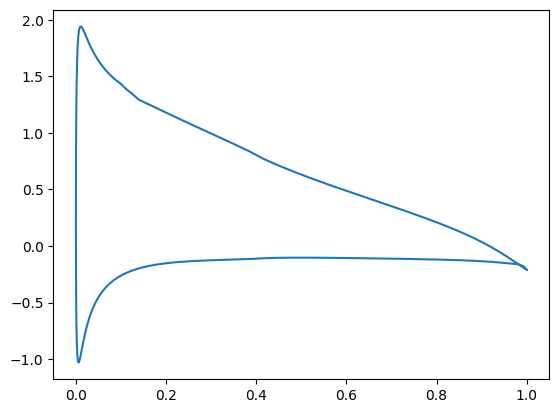

In [70]:
import xfoil as xfoil
xfoil.init()

plt.plot(xfoil.x, -xfoil.cp(5.1232, 0.35, 5e6))

As you can see, the pressure coefficient can be obtained by the function `cp` and the locations of each obtained `cp` is stored in `xfoil.x`. `cp` accepts three arguments in the following order: angle of attack $\alpha$, mach, and Reynolds number. The angle of attack $\alpha$ must be between 1 and 6. The Mach number must be between 0.3 and 0.6. The Reynolds number must be between $10^6$ and $10^7$. Any combination in these intervals should work. Any combination outside these intervals will most likely result into an error.

Summarized:
* $\alpha \in [1^\circ, 6^\circ]$
* $M_\infty \in [0.3, 0.6]$
* $Re \in [10^6, 10^7]$

**EXERCISE 8**

Using $N = 100$ random uniformly distributed samples in the $\alpha$ and $M_\infty$ intervals described above, and fix $Re = 10^6$.  Plot the mean and (mean $\pm$ standard deviation) of the pressure coefficient. Be aware of the fact that you *cannot* pass vector inputs to the function `cp()`, it accepts only 3 scalars.

**Hint:**
Use `np.random.uniform(a, b, 100)` to get 100 uniform random samples on the interval $[a, b]$.

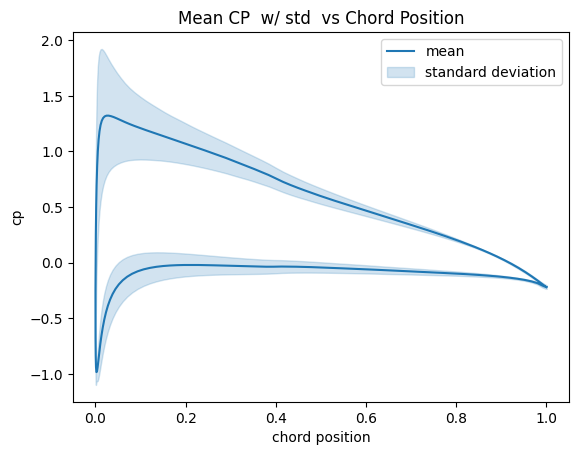

In [71]:
N = 100
alpha_set = np.random.uniform(1, 6, N)[:,np.newaxis]
M_set = np.random.uniform(0.3, 0.6, N)[:,np.newaxis]
Re_set = np.random.uniform(1e6, 1e7, N)[:,np.newaxis]

sample_set = np.hstack((alpha_set,M_set,Re_set))

xfoil_output = np.empty((N,len(xfoil.x)))

for c,args in enumerate(sample_set):
    xfoil_output[c,:] = -(xfoil.cp(*args).flatten())
    # xfoil_output.append(-xfoil.cp(*args))


avg_cp = np.mean(xfoil_output, axis = 0)
std_cp = np.std(xfoil_output, axis = 0)
cp_plus = avg_cp + std_cp
cp_minus = avg_cp - std_cp

plt.title("Mean CP  w/ std  vs Chord Position")
plt.plot(xfoil.x, avg_cp, label = 'mean')
plt.xlabel("chord position")
plt.ylabel("cp")


plt.fill_between(xfoil.x.flatten(), cp_minus, cp_plus, color='C0', alpha=0.2, label = 'standard deviation')
plt.legend()



**EXERCISE 9**

Use a 2d tensor grid to determine the mean and standard deviation of the `xfoil`-problem. It is not possible to plot the exact error as we did previously, since the exact value is not known. Therefore, create a plot that plots the consecutive difference:

$$e_n = \left\|\text{(Estimate with $(M+1)^2$ nodes)} - \text{(Estimate with $M^2$ nodes)}\right\|$$

where $\|\cdot\|$ is e.g. the $\ell^2$-norm.  Note that out quadrature is built for $\mathcal{U}(0,1)$, so some scaling will be necessary to apply it to $\mathcal{U}(1,6)$, etc.  You can scale the nodes/weights, or just scale the input to XFoil.

**EXERCISE 10**

Again fix $Re = 10^6$. Use your Smolyak sparse grid code to determine the mean and standard deviation of the `xfoil`-problem with this fixed Reynolds number.  Recreate the plot of the consecutive difference, and compare convergence with the tensor-product method.